In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow import keras

In [2]:
# Cargamos el dataset
dataset = pd.read_csv('wine.data', header=None,skiprows=1)
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
#  Ahora vamos a separar los datos de entrenamiento y los datos de prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:, 1:], dataset.iloc[:, 0], test_size=0.35)

len(dataset),len(X_train),len(X_test)

(178, 115, 63)

In [5]:
# Normalizamos nuestros conjuntos de datos
# X_train_mean = X_train.mean()   
# X_train_std = X_train.std()
# X_train = (X_train - X_train_mean) / X_train_std

# X_test_mean = X_test.mean()
# X_test_std = X_test.std()
# X_test = (X_test - X_test_mean) / X_test_std

X_train = X_train/X_train.max()
X_test = X_test/X_test.max()



In [ ]:
y_train.head()

In [ ]:
X_train.head()

In [ ]:
# X_train = np.array(X_train)
# y_train = np.array(y_train)

In [ ]:
len(X_train),len(y_train)

In [12]:
model = Sequential([
    Dense(13, input_shape=(13,), activation="relu"),
    Dense(64, activation="sigmoid"),
    Dense(1, activation="softmax")
])

In [7]:
model.build(input_shape=(None, 13))


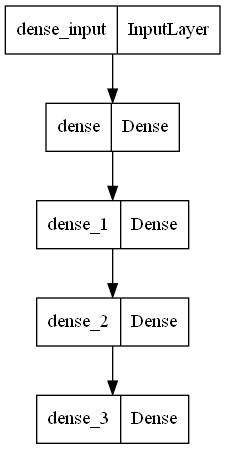

In [8]:
keras.utils.plot_model(model)

In [13]:
# Probaremos varios optimizadores
# model.compile(optimizer=("sgd", "rmsprop", "adagrad", "adadelta", "adam", "adamax", "nadam"),
from tensorflow.keras.optimizers import Adam, SGD
model.compile(optimizer=SGD(learning_rate=0.1),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [14]:
history_small_model=model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=2)

Epoch 1/100


c:\Users\pepe2\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\util\dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


7/7 - 1s - loss: 0.0000e+00 - accuracy: 0.3301 - val_loss: 0.0000e+00 - val_accuracy: 0.3333 - 605ms/epoch - 86ms/step
Epoch 2/100
7/7 - 0s - loss: 0.0000e+00 - accuracy: 0.3301 - val_loss: 0.0000e+00 - val_accuracy: 0.3333 - 40ms/epoch - 6ms/step
Epoch 3/100
7/7 - 0s - loss: 0.0000e+00 - accuracy: 0.3301 - val_loss: 0.0000e+00 - val_accuracy: 0.3333 - 38ms/epoch - 5ms/step
Epoch 4/100


c:\Users\pepe2\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\util\dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


7/7 - 0s - loss: 0.0000e+00 - accuracy: 0.3301 - val_loss: 0.0000e+00 - val_accuracy: 0.3333 - 41ms/epoch - 6ms/step
Epoch 5/100
7/7 - 0s - loss: 0.0000e+00 - accuracy: 0.3301 - val_loss: 0.0000e+00 - val_accuracy: 0.3333 - 44ms/epoch - 6ms/step
Epoch 6/100
7/7 - 0s - loss: 0.0000e+00 - accuracy: 0.3301 - val_loss: 0.0000e+00 - val_accuracy: 0.3333 - 41ms/epoch - 6ms/step
Epoch 7/100
7/7 - 0s - loss: 0.0000e+00 - accuracy: 0.3301 - val_loss: 0.0000e+00 - val_accuracy: 0.3333 - 38ms/epoch - 5ms/step
Epoch 8/100
7/7 - 0s - loss: 0.0000e+00 - accuracy: 0.3301 - val_loss: 0.0000e+00 - val_accuracy: 0.3333 - 39ms/epoch - 6ms/step
Epoch 9/100
7/7 - 0s - loss: 0.0000e+00 - accuracy: 0.3301 - val_loss: 0.0000e+00 - val_accuracy: 0.3333 - 38ms/epoch - 5ms/step
Epoch 10/100
7/7 - 0s - loss: 0.0000e+00 - accuracy: 0.3301 - val_loss: 0.0000e+00 - val_accuracy: 0.3333 - 39ms/epoch - 6ms/step
Epoch 11/100
7/7 - 0s - loss: 0.0000e+00 - accuracy: 0.3301 - val_loss: 0.0000e+00 - val_accuracy: 0.3333 - 

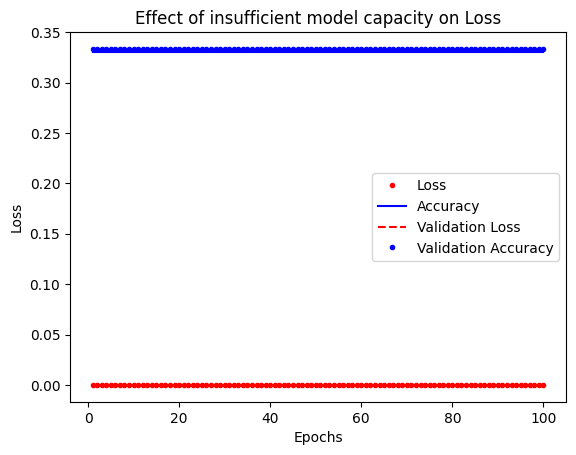

In [11]:
loss = history_small_model.history["loss"]
epochs = range(1, 101)
acc = history_small_model.history["accuracy"]

plt.plot(epochs, loss, "r.",label="Loss")
plt.plot(epochs,acc, "b",label="Accuracy")
plt.plot(epochs, history_small_model.history["val_loss"], "r--",label="Validation Loss")
plt.plot(epochs, history_small_model.history["val_accuracy"], "b.",label="Validation Accuracy")
plt.title("Effect of insufficient model capacity on Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()